# Toy examples 2.0

Here I want to show how propensity score works using toy examples, so that this theory can be further developed on large models.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from scipy.stats import gaussian_kde
from transformers import AutoTokenizer, AutoModelForMaskedLM
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import multivariate_normal, norm
from utils_update import compute_metrics
import logging

from hep_ml.metrics_utils import ks_2samp_weighted
from hep_ml import reweight

logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)
np.random.seed(48)

### Controlable generation data

Controlled generation of data and shift.

In [45]:
def generate_dataset(n_samples, n_features):
    X = np.random.randn(n_samples, n_features)
    noise = np.random.randn(n_samples)
    y = 2 * X[:, 0] + 3 * X[:, 1] + noise
    
    return X, y

def make_distribution_shift(X, y, shift_factor):
    X_shifted = X.copy()
    X_shifted[:, 0] *= shift_factor
    X_shifted[:, 1] /= shift_factor
    
    y_shifted = y * shift_factor
    
    return X_shifted, y_shifted

Let's look at one example of the generation result.

In [46]:
n_samples = 2000
n_features = 2
X_train, y_train = generate_dataset(n_samples, n_features)
X_shifted, y_shifted = make_distribution_shift(X_train, y_train, shift_factor=2)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
X_shifted_train, X_shifted_test, y_shifted_train, y_shifted_test = train_test_split(X_shifted, y_shifted, test_size=0.25, random_state=42)

In [4]:
regressor = LinearRegression().fit(X_train, y_train)

print(f"R2 score on original test data: {r2_score(y_test, regressor.predict(X_test))}")
print(f"MSE score on original test data: {mean_squared_error(y_test, regressor.predict(X_test))}")

R2 score on original test data: 0.9302389747029665
MSE score on original test data: 0.9910085342242777


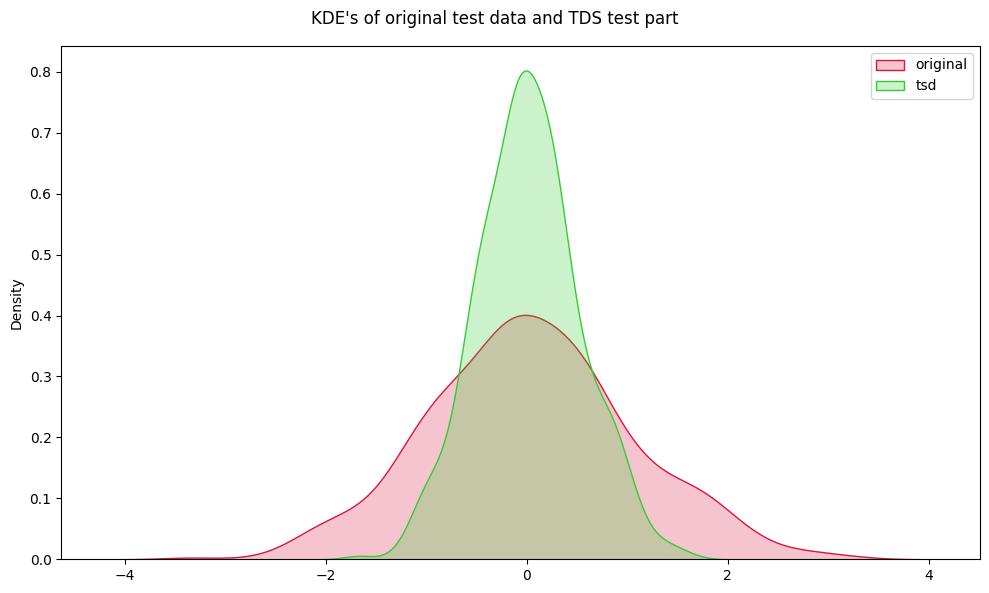

In [5]:
fig, ax = plt.subplots(figsize=(10, 6))
fig.suptitle("KDE's of original test data and TDS test part")
sns.kdeplot(data=X_test[:, 1],
            color='crimson', label='original', fill=True, ax=ax)
sns.kdeplot(data=X_shifted_test[:, 1],
            color='limegreen', label='tsd', fill=True, ax=ax)
ax.legend()
plt.tight_layout()
plt.show()

In [6]:
print(f"R2 score on TDS data w/o weights: {r2_score(y_shifted_test, regressor.predict(X_shifted_test))}")
print(f"MSE score on TDS data w/o weights: {mean_squared_error(y_shifted_test, regressor.predict(X_shifted_test))}")

R2 score on TDS data w/o weights: 0.5659823524106822
MSE score on TDS data w/o weights: 24.662205919914914


Now we need to train a classifier that can output for each data sample the probability of belonging to the new distribution. Today we will be using CalibratedClassifierCV and RandomForest.

In [25]:
sample_from_old = np.random.choice(len(X_train), size=250, replace=False)
sample_from_new = np.random.choice(len(X_shifted_train), size=250, replace=False) 

X_logreg = np.concatenate((X_train[sample_from_old], X_shifted_train[sample_from_new]), axis=0)
t = [1] * len(sample_from_old) + [0] * len(sample_from_new)

X_train_lg, _, y_train_lg, _ = train_test_split(X_logreg, t, test_size=0.0001, random_state=None, shuffle=True)
ccv = CalibratedClassifierCV(RandomForestClassifier(n_estimators=300, min_samples_leaf=40, max_depth=3), cv=3)

calibr = ccv.fit(X_train_lg, y_train_lg)

We can now get the predicted weights for the original test sample and the true weights using the pdf.

In [26]:
weights = [calibr.predict_proba(item.reshape(1, -1))[0][0] / (1 - calibr.predict_proba(item.reshape(1, -1))[0][0]) for item in X_test]

In [49]:
mvn_test = multivariate_normal(mean=np.mean(X_test, axis=0), cov=np.cov(X_test, rowvar=False))
mvn_shifted_test = multivariate_normal(mean=np.mean(X_shifted_test, axis=0), cov=np.cov(X_shifted_test, rowvar=False))

pdf_test = mvn_test.pdf(X_test)
pdf_shifted_test = mvn_shifted_test.pdf(X_test)

true_weights = pdf_shifted_test / pdf_test

Visualise distributions with predicted and true weights.

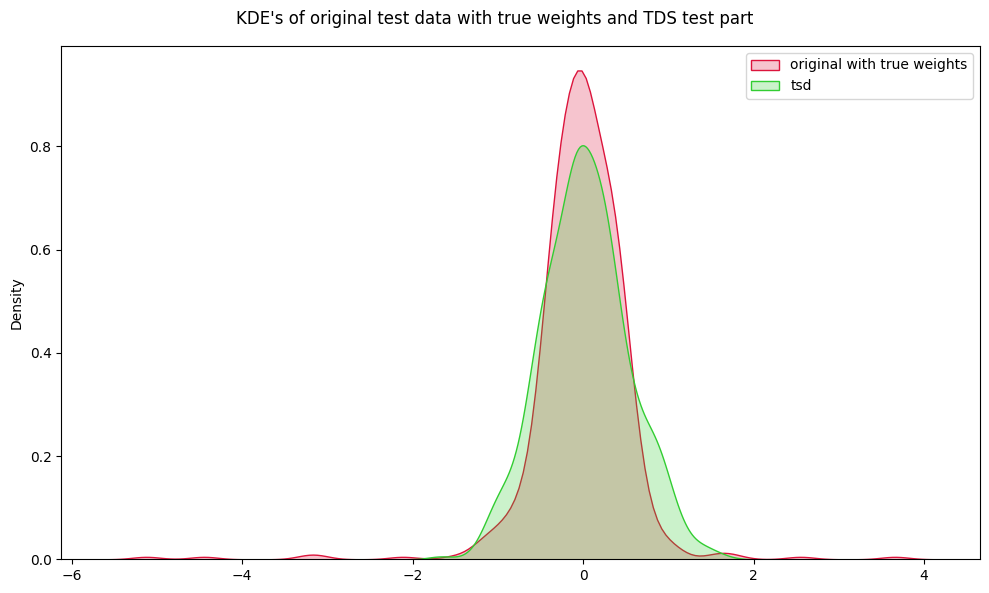

In [36]:
fig, ax = plt.subplots(figsize=(10, 6))
fig.suptitle("KDE's of original test data with true weights and TDS test part")
sns.kdeplot(data=true_weights * X_test[:, 1],
            color='crimson', label='original with true weights', fill=True, ax=ax)
sns.kdeplot(data=X_shifted_test[:, 1],
            color='limegreen', label='tsd', fill=True, ax=ax)
ax.legend()
plt.tight_layout()
plt.show()

equality of distibutions for each feature ≠ equality of multivariate distributions

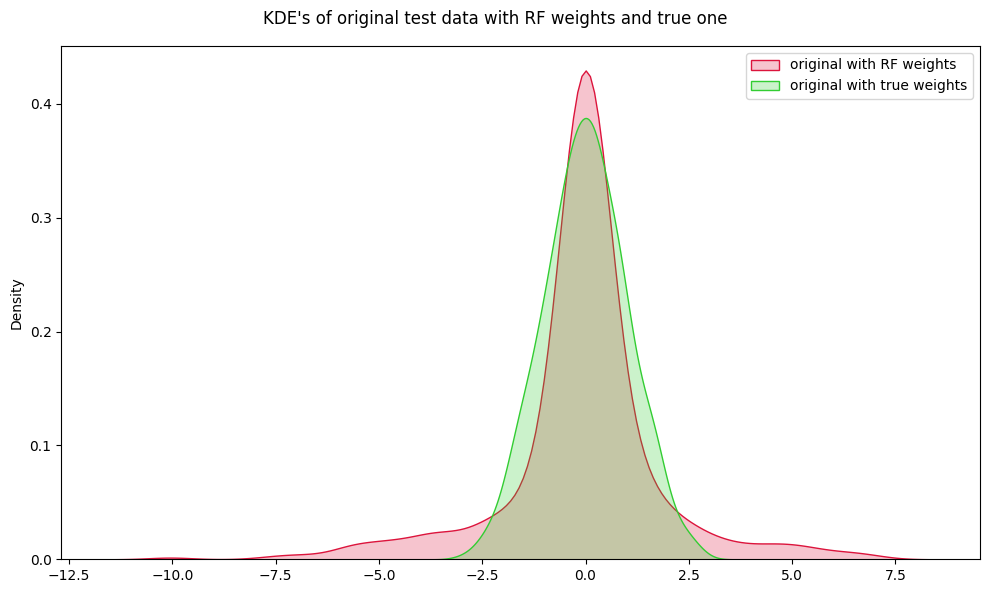

In [24]:
fig, ax = plt.subplots(figsize=(10, 6))
fig.suptitle("KDE's of original test data with RF weights and true one")
sns.kdeplot(data=weights * X_test[:, 0],
            color='crimson', label='original with RF weights', fill=True, ax=ax)
sns.kdeplot(data=true_weights * X_test[:, 0],
            color='limegreen', label='original with true weights', fill=True, ax=ax)
ax.legend()
plt.tight_layout()
plt.show()

In [30]:
print(f"R2 score on TDS data with weights: {r2_score(y_shifted_test, regressor.predict(X_shifted_test), sample_weight=weights)}")
print(f"MSE score on TDS data with weights: {mean_squared_error(y_shifted_test, regressor.predict(X_shifted_test), sample_weight=weights)}")

R2 score on TDS data with weights: 0.6728811341186796
MSE score on TDS data with weights: 16.975412129052124


### Confidence intervals across different shift values

In [18]:
n_samples = 2000
n_features = 2
X_train_true, y_train_true = generate_dataset(n_samples, n_features)
X_train, X_test, y_train, y_test = train_test_split(X_train_true, y_train_true, test_size=0.25, random_state=42)

ci_list = []
for item in tqdm([1, 1.5, 2.0, 2.5, 3, 5, 8, 10]):
    X_shifted, y_shifted = make_distribution_shift(X_train_true, X_train_true, shift_factor=2)

    X_shifted_train, X_shifted_test, y_shifted_train, y_shifted_test = train_test_split(X_shifted, y_shifted, test_size=0.25, random_state=42)
    
    ci = compute_metrics(X_train, y_train, X_test, X_shifted_train)
    ci_list.append(ci)

  0%|          | 0/8 [00:00<?, ?it/s]

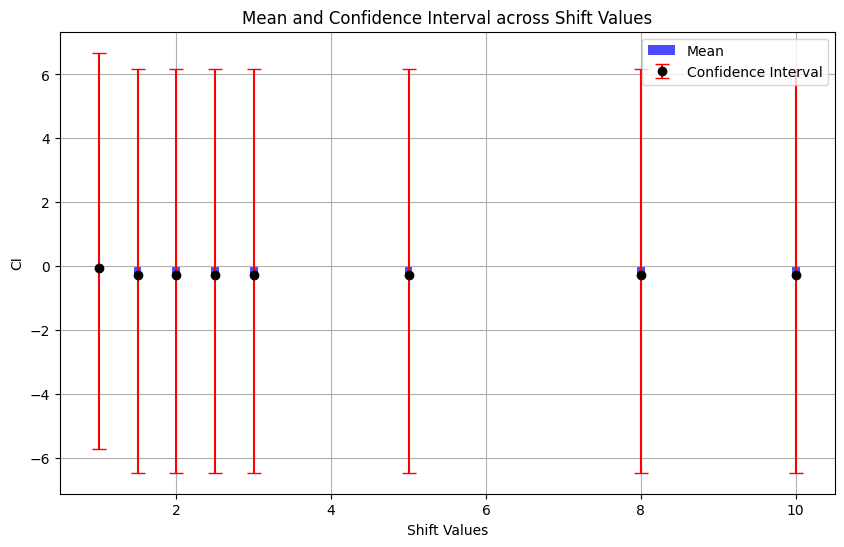

In [19]:
means = np.array([item[1][0] for item in ci_list])
shift_values = [1, 1.5, 2.0, 2.5, 3, 5, 8, 10]
lower_bounds = np.array([item[1][1][0] for item in ci_list])
upper_bounds = np.array([item[1][1][1] for item in ci_list])

plt.figure(figsize=(10, 6))
plt.bar(shift_values, means, width=0.1, color='blue', alpha=0.7, label='Mean')
plt.errorbar(shift_values, means, yerr=[means - lower_bounds, upper_bounds - means],
             fmt='o', color='black', ecolor='red', capsize=5, label='Confidence Interval')
plt.xlabel('Shift Values')
plt.ylabel('CI')
plt.title('Mean and Confidence Interval across Shift Values')
plt.legend()
plt.grid(True)
plt.show()

### HEP_ml approach

KS = Kolmogorov-Smirnov distance

In [21]:
from hep_ml.metrics_utils import ks_2samp_weighted

hist_settings = {'bins': 100, 'density': True, 'alpha': 0.7}
original_weights = np.ones(len(X_test))

def draw_distributions(original, target, new_original_weights):
    plt.figure(figsize=[15, 7])
    for id, column in enumerate([0, 1], 1):
        xlim = np.percentile(np.hstack([target[:, column]]), [0.01, 99.99])
        plt.subplot(2, 3, id)
        plt.hist(original[:, column], weights=new_original_weights, range=xlim, **hist_settings)
        plt.hist(target[:, column], range=xlim, **hist_settings)
        plt.title(column)
        print('KS over ', column, ' = ', ks_2samp_weighted(original[:, column], target[:, column], 
                                         weights1=new_original_weights, weights2=np.ones(len(target), dtype=float)))

KS over  0  =  0.1810000000000001
KS over  1  =  0.1770000000000001


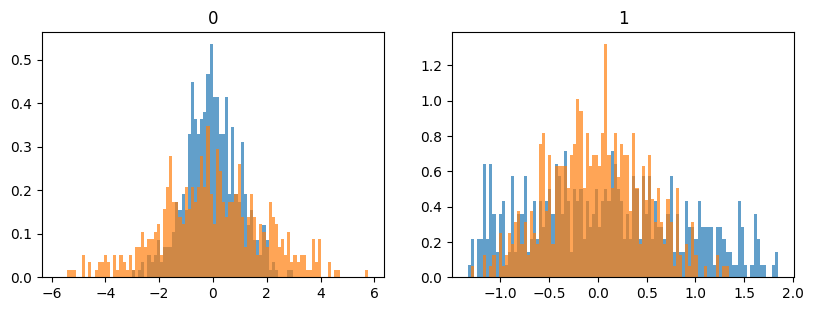

In [22]:
draw_distributions(X_test, X_shifted_test, original_weights)

KS over  0  =  0.11719918369832527
KS over  1  =  0.060437946774664075


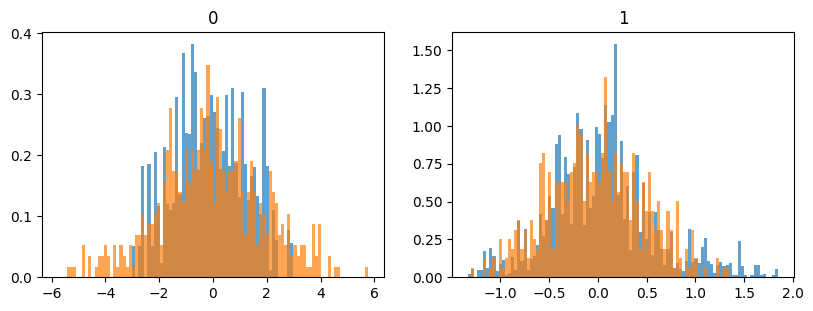

In [23]:
from hep_ml import reweight

bins_reweighter = reweight.BinsReweighter(n_bins=20, n_neighs=1.)
bins_reweighter.fit(X_train, X_shifted_train)

bins_weights_test = bins_reweighter.predict_weights(X_test)
draw_distributions(X_test, X_shifted_test, bins_weights_test)

KS over  0  =  0.08192879478367421
KS over  1  =  0.11473317997662968


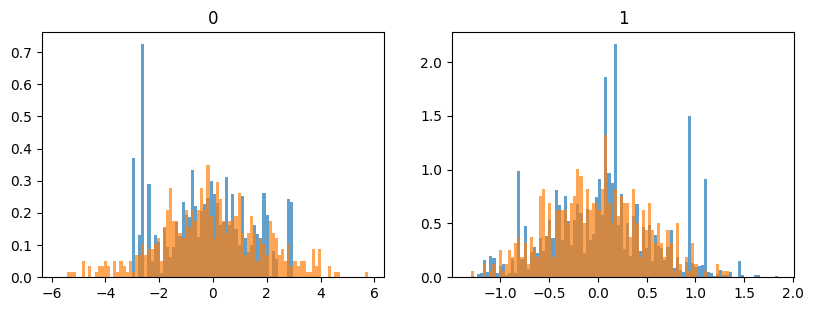

In [24]:
reweighter = reweight.GBReweighter(n_estimators=300, learning_rate=0.01, max_depth=5, min_samples_leaf=100, 
                                   gb_args={'subsample': 0.9})
reweighter.fit(X_train, X_shifted_train)

gb_weights_test = reweighter.predict_weights(X_test)
draw_distributions(X_test, X_shifted_test, gb_weights_test)

Let's check how well a classifier is able to distinguish these distributions. 
ROC AUC is taken as a measure of quality.

Before that I trained a classifier do distinguish these distributions. 
If ROC AUC = 0.5 on test, distibutions are identical, if ROC AUC = 1.0, they are ideally separable.

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier

data = np.concatenate([X_test, X_shifted_test])
labels = np.array([0] * len(X_test) + [1] * len(X_shifted_test))

weights = {}
weights['original'] = np.ones(len(X_test))
weights['bins'] = bins_weights_test
weights['gb_weights'] = gb_weights_test


for name, new_weights in weights.items():
    W = np.concatenate([new_weights / new_weights.sum() * len(X_shifted_test), [1] * len(X_shifted_test)])
    Xtr, Xts, Ytr, Yts, Wtr, Wts = train_test_split(data, labels, W, random_state=42, train_size=0.51)
    clf = GradientBoostingClassifier(subsample=0.3, n_estimators=50).fit(Xtr, Ytr, sample_weight=Wtr)
    
    print(name, roc_auc_score(Yts, clf.predict_proba(Xts)[:, 1], sample_weight=Wts))

original 0.7555778055903213
bins 0.5800727431522571
gb_weights 0.5848319114827069


### HEP_ml approach with NLP data

This section discusses the use of [hep_ml](https://github.com/arogozhnikov/hep_ml) library functions for sample reweighting as applied to text data.

For the experiments we chose texts those generated by two generative models: [ChatGPT](https://chat.openai.com/) and [Cohere](https://docs.cohere.com/docs/the-cohere-platform). Each on them receives one prompt as input - a paper from the arxiv resource and asked to generate abstract to it. 

Source: [M4](https://github.com/mbzuai-nlp/M4)

Example prompt:
```
Generate an abstract for work with title: Polymer Quantum Mechanics and its Continuum Limit. Describe the motivation for the research, the key ideas and methodology, the results obtained, problem work attempts to solve and any practical or theoretical applications from your findings or implications for future research in a formal academic and scientific writing voice. Use the first plural person form. Use active voice.
```

ChatGPT:
```
In this paper, we investigate the continuum limit of polymer quantum mechanics. The aim of our work is to better understand the quantum behavior of polymers and its relationship to the classical theory. Our research attempts to clarify the nature of the continuum limit and determine the correctness of the approximations made. Specifically, we study...
```

Cohere:
```
We consider a system of many polymers in solution that interact via an external force that is applied to each pair of polymers. We study the statistical equilibrium of this system, and find that the polymers form clusters whose sizes are given by a power law distribution. This is in contrast to the traditional picture of polymers in solution, where the thermodynamic equilibrium is described by a mean-field theory based on the solution of the mean-field...
```

In [2]:
# texts = pd.read_csv('llm_propensity/arxiv_llm.csv')
texts = pd.read_csv('llm_propensity/QA-time-expansion.csv')

In [3]:
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
model = AutoModelForMaskedLM.from_pretrained("google-bert/bert-base-uncased")

The most basic BERT encoder was chosen to represent the texts numerically. Each text passes through the tokenizer and encoder, and then the `[CLS]-token` values, which is designed to store information about the entire text, are extracted.

In [4]:
def cls_matrix(texts_list):
    current_cls_matrix = np.zeros((len(texts_list), 768))
    for j, sent in enumerate(tqdm(texts_list)):
        tokenized_sent = tokenizer.encode_plus(sent, 
                                           add_special_tokens = True, 
                                           truncation = True,  
                                           return_attention_mask=False, 
                                           return_token_type_ids=False, 
                                           return_tensors = 'pt')

        _cls = model.bert(tokenized_sent['input_ids']).last_hidden_state[:,0,:]
        current_cls_matrix[j, :] = _cls.detach().numpy()[0]
    return current_cls_matrix

In [5]:
# original = cls_matrix(texts["chatgpt"].tolist())
# original_train, original_test = original[:2000, :], original[2000:, :]

# target = cls_matrix(texts["cohere"].tolist())
# target_train, target_test = target[:2000, :], target[2000:, :]

original = cls_matrix(texts[texts["Time"] == 'original']["Question"].tolist())
original_train, original_test = original[:80, :], original[20:, :]

target = cls_matrix(texts[texts["Time"] == 'past']["Question"].tolist())
target_train, target_test = target[:60, :], target[60:, :]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

First of all, we derive for the first and last 3 features a comparison of the distributions of texts from ChatGPT and texts from Cohere.

In [6]:
hist_settings = {'bins': 30, 'density': True, 'alpha': 0.7}
original_weights = np.ones(len(original_test))

def draw_distributions(original, target, new_original_weights):
    plt.figure(figsize=[15, 7])
    for id, column in enumerate([0, 1, 2, 765, 766, 766], 1):
        xlim = np.percentile(np.hstack([target[:, column]]), [0.01, 99.99])
        plt.subplot(2, 3, id)
        plt.hist(original[:, column], weights=new_original_weights, range=xlim, label="original", **hist_settings, )
        plt.hist(target[:, column], range=xlim, label="target", **hist_settings)
        plt.title(column)
        plt.legend()
        print('KS over ', column, 'feature = ', ks_2samp_weighted(original[:, column], target[:, column], 
                                         weights1=new_original_weights, weights2=np.ones(len(target), dtype=float)))

KS over  0 feature =  0.21711956521739129
KS over  1 feature =  0.3154891304347819
KS over  2 feature =  0.337771739130435
KS over  765 feature =  0.20244565217391297
KS over  766 feature =  0.18994565217391263
KS over  766 feature =  0.18994565217391263


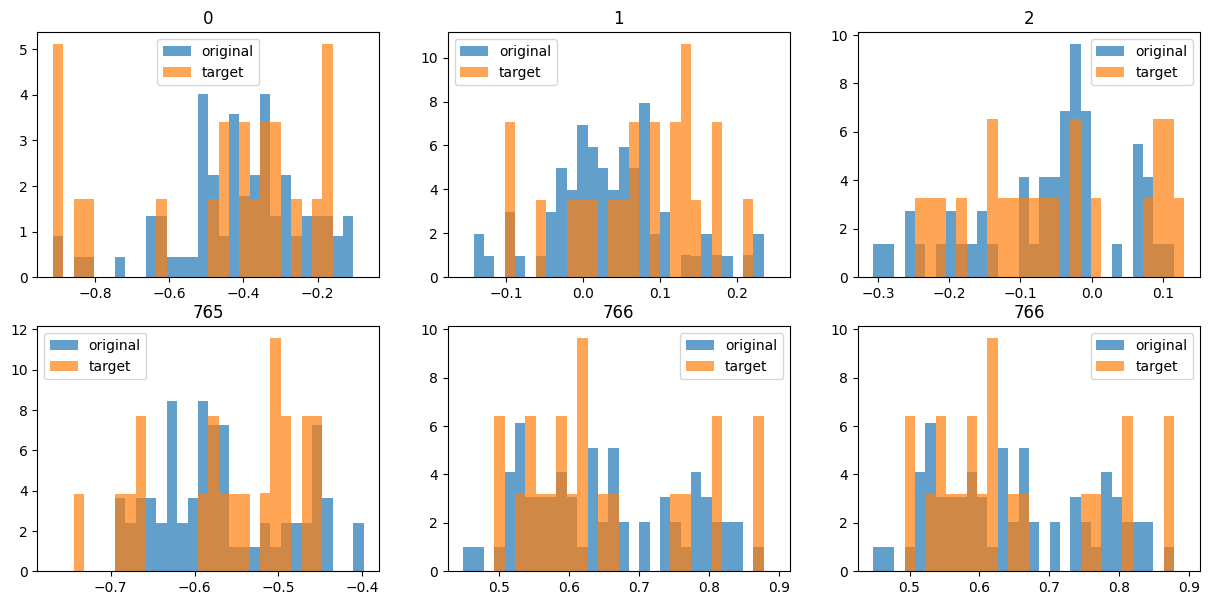

In [7]:
draw_distributions(original_test, target_test, original_weights)

We can also look at the average of all the attributes of this metric:

In [8]:
average_k2 =[]
for i in range(768):
    average_k2.append(ks_2samp_weighted(original_test[:, i], target_test[:, i], weights1=np.ones(len(original_test)), weights2=np.ones(len(target_test), dtype=float)))

print("Mean k2 on non-weighted test data:", np.mean(average_k2))
print("Median k2 on non-weighted test data:", np.median(average_k2))

Mean k2 on non-weighted test data: 0.2836199331974635
Median k2 on non-weighted test data: 0.27038043478260815


We will now proceed to the weighting. For weighting multidimensional data, `GradientBoostingReweighter` is implemented in the hep_ml package.

KFold prediction using folds column
KS over  0 feature =  0.19262766738184117
KS over  1 feature =  0.2877471825064546
KS over  2 feature =  0.30968428488787514
KS over  765 feature =  0.15463080559708575
KS over  766 feature =  0.17416844478946497
KS over  766 feature =  0.17416844478946497


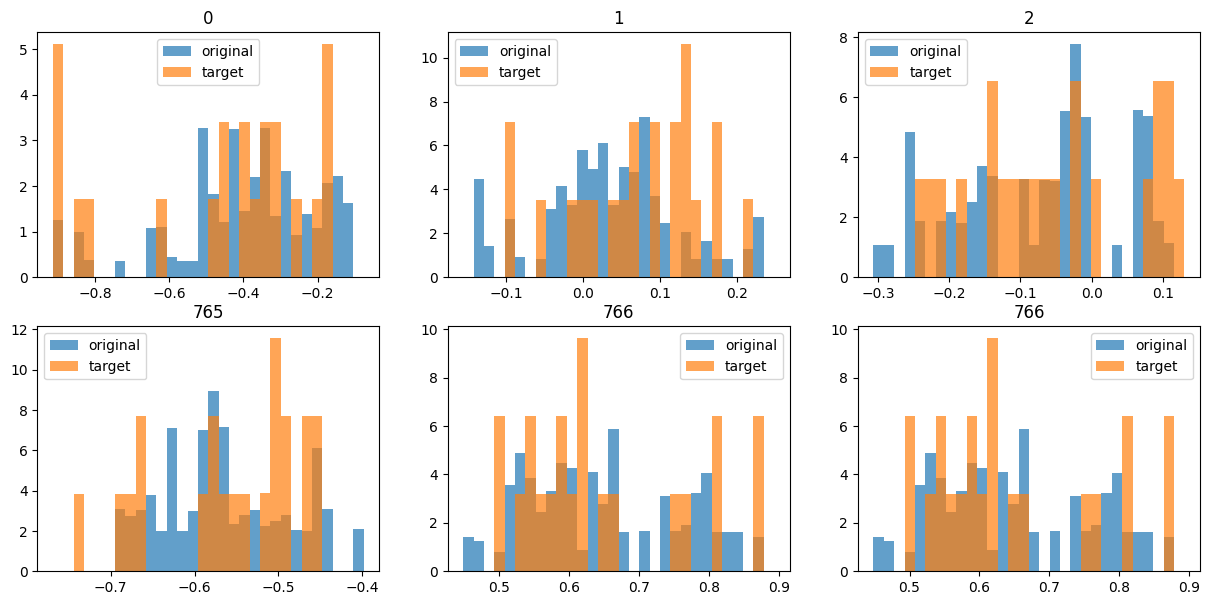

In [9]:
reweighter_base = reweight.GBReweighter(n_estimators=30, learning_rate=0.009, max_depth=20, min_samples_leaf=1, 
                                   gb_args={'subsample': 0.9}) # 0.20, 0.19
reweighter = reweight.FoldingReweighter(reweighter_base, n_folds=3)
reweighter.fit(original_train, target_train)

gb_weights_test = reweighter.predict_weights(original_test)
draw_distributions(original_test, target_test, gb_weights_test)

In [10]:
average_k2 =[]
for i in range(768):
    average_k2.append(ks_2samp_weighted(original_test[:, i], target_test[:, i], weights1=gb_weights_test, weights2=np.ones(len(target_test), dtype=float)))
    
print("Mean k2 on weighted test data:", np.mean(average_k2))
print("Median k2 on weighted test data:", np.median(average_k2)) 

Mean k2 on weighted test data: 0.26404275853312603
Median k2 on weighted test data: 0.2558532892948643


We see that the mean and median values for all features have decreased, which means that the original distribution with weights is more consistent with the target distribution.

You can also see the distribution of the predicted weights:

Text(0.5, 1.0, 'predicted weights')

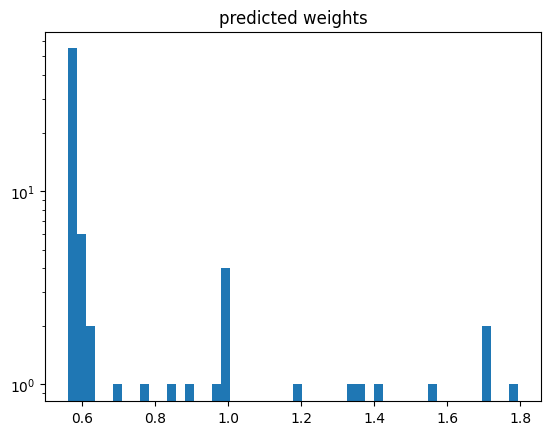

In [11]:
plt.hist(gb_weights_test, bins=50)
plt.yscale('log')
plt.title('predicted weights')

## Bootstrap over HEP_ml weights

In [12]:
def bootstrap_resampling(data, statistic_function, with_weights=None, num_samples=1000, alpha=0.05, seed=42):
    np.random.seed(seed) 
    sample_statistics = []

    for _ in range(num_samples):
        # Generate a bootstrap sample with replacement
        if with_weights is not None:
            normalized_weights = np.array(with_weights) / sum(with_weights)
            bootstrap_ind = np.random.choice(len(data), size=len(data), replace=True, p=normalized_weights)
        else:
            bootstrap_ind = np.random.choice(len(data), size=len(data), replace=True)

        bootstrap_sample = data[bootstrap_ind]
        # Calculate the statistic on the bootstrap sample
        sample_statistic = statistic_function.predict(bootstrap_sample)
        sample_statistics.append(sample_statistic)

    mean = np.mean(sample_statistics)
    lower_bound = np.percentile(sample_statistics, 100 * (alpha / 2))
    upper_bound = np.percentile(sample_statistics, 100 * (1 - alpha / 2))

    confidence_interval = (lower_bound, upper_bound)
    return mean, confidence_interval  

In [13]:
y_train = np.random.choice([0,1], 80, replace=True)

In [14]:
regressor = LinearRegression().fit(original_train, y_train)

In [15]:
first_ci = bootstrap_resampling(target_test, regressor) 
first_ci

(1.9705670203770012, (-2.454846802184531, 6.786078999033093))

In [16]:
regressor_weighted = LinearRegression().fit(original_train, 
                                        y_train, 
                                        sample_weight=reweighter.predict_weights(original_train))

second_ci = bootstrap_resampling(target_test, regressor_weighted, reweighter.predict_weights(target_test))
second_ci

KFold prediction using folds column
KFold prediction using random reweighter (length of data passed not equal to length of train)


(2.5784988738452546, (-1.71667854198708, 6.790435224598117))

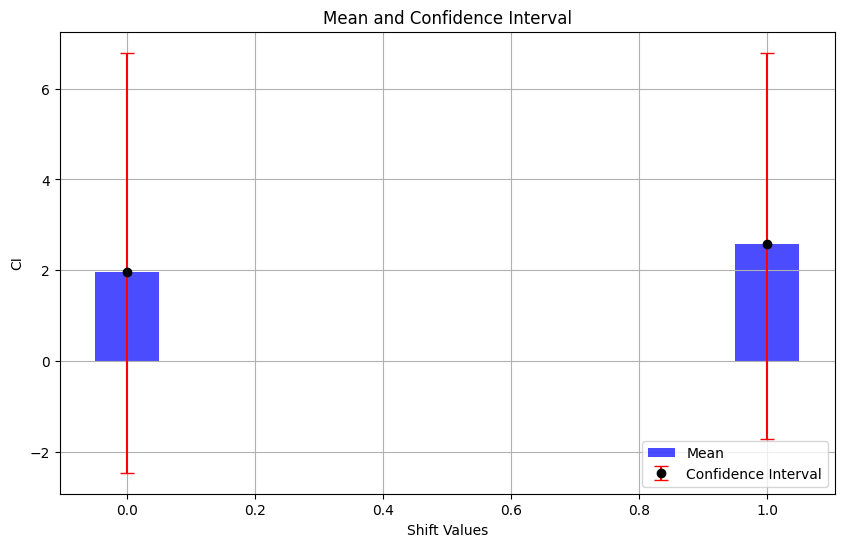

In [17]:
means = np.array([first_ci[0], second_ci[0]])
shift_values = [0, 1]
lower_bounds = np.array([first_ci[1][0], second_ci[1][0]])
upper_bounds = np.array([first_ci[1][1], second_ci[1][1]])

plt.figure(figsize=(10, 6))
plt.bar(shift_values, means, width=0.1, color='blue', alpha=0.7, label='Mean')
plt.errorbar(shift_values, means, yerr=[means - lower_bounds, upper_bounds - means],
             fmt='o', color='black', ecolor='red', capsize=5, label='Confidence Interval')
plt.xlabel('Shift Values')
plt.ylabel('CI')
plt.title('Mean and Confidence Interval')
plt.legend()
plt.grid(True)
plt.show()

## Use draft package 'propensity_reweighting'

In [21]:
import yaml

with open('./propensity_reweighting/config/config.yaml', 'r') as file:
    config = yaml.safe_load(file)
    
texts = pd.read_csv('llm_propensity/QA-time-expansion.csv')

In [22]:
original = texts[texts["Time"] == 'original']["Question"].tolist()
target = texts[texts["Time"] == 'future']["Question"].tolist()

In [23]:
from propensity_reweighting.src.reweight import PropensityReweighter

pr = PropensityReweighter(config)
pr.fit(original, target)

Mean and median k2 on non-weighted test data: 0.23526952273965143 - 0.21983660130718963
KFold prediction using folds column
Mean and median k2 on weighted test data: 0.19657440313402483 - 0.1850546617189576


In [24]:
weights = pr.predict(target)
weights[:10]

KFold prediction using random reweighter (length of data passed not equal to length of train)


array([1.70861389, 1.40289498, 1.39742113, 1.58162763, 1.42299515,
       1.4178171 , 1.61189024, 1.85287881, 1.75783886, 1.93290824])

Text(0.5, 1.0, 'predicted weights')

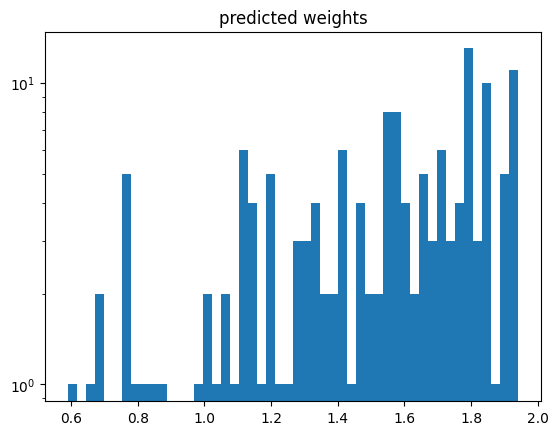

In [25]:
plt.hist(weights, bins=50)
plt.yscale('log')
plt.title('predicted weights')

In [1]:
import pandas as pd
texts = pd.read_csv('./QA-time-expansion.csv')

In [3]:
texts[texts['Time'] == 'original']

,Question,Answer,Time
0,Who was President Reagan's Secretary for Defen...,Frank Carlucci,original
1,Who was President Reagan's Secretary for Defen...,Frank Carlucci,original
2,Who was President Reagan's Secretary for Defen...,Frank Carlucci,original
3,Who was the Prime Minister of Australia in 1983?,Bob Hawke,original
4,Who was the Prime Minister of Australia in 1984?,Bob Hawke,original
...,...,...,...
311,"What major war began on 10 October, 1899??",Second Boer War,original
319,Who was the biggest selling female artist in A...,Mariah Carey,original
322,Which films did Steven Spielberg direct that w...,"""E.T. the Extra-Terrestrial"" and ""Jurassic Park""",original
324,How many UK top 40 hits did Prince have in the...,22,original


In [8]:
texts[texts['Time'] == 'original']["Question"].iloc[:5].tolist()

["Who was President Reagan's Secretary for Defense in 1987?",
 "Who was President Reagan's Secretary for Defense in 1988?",
 "Who was President Reagan's Secretary for Defense in 1989?",
 'Who was the Prime Minister of Australia in 1983?',
 'Who was the Prime Minister of Australia in 1984?']

In [6]:
texts[texts['Time'] == 'future']["Question"].iloc[:5].tolist()

['Which American won the Nobel Prize for Literature in 1936?',
 'Which American won the Nobel Prize for Literature in 1938?',
 'Which American won the Nobel Prize for Literature in 1948?',
 'Which American won the Nobel Prize for Literature in 1949?',
 'Which American won the Nobel Prize for Literature in 1954?']